# Annolid on Detectron2 Tutorial 2 : Train a Model

This is modified from the official colab tutorial of detectron2. Here, we will 

* Train (fine-tune) a detectron2 model on our dataset.

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


In [1]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

You should consider upgrading via the '/Users/chenyang/miniconda3/envs/ceed/bin/python -m pip install --upgrade pip' command.


torch:  1.9 ; cuda:  1.9.0


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/1.9.0/torch1.9/index.html


You should consider upgrading via the '/Users/chenyang/miniconda3/envs/ceed/bin/python -m pip install --upgrade pip' command.


In [3]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

no gpu


# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in COCO format.

## Prepare the dataset

## Upload a labeled dataset.
The following code is expecting the dataset in the COCO format to be in a ***.zip*** file. For example: ```sample_dataset.zip``` \
Note: please make sure there is no white space in your file path if you encounter file not found issues.

In [6]:
!pip install gdown 
!gdown --id 1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR

You should consider upgrading via the '/Users/chenyang/miniconda3/envs/ceed/bin/python -m pip install --upgrade pip' command.


Downloading...
From: https://drive.google.com/uc?id=1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR
To: /Users/chenyang/Desktop/Developer/cpl/annolid/book/tutorials/novelctrlk6_8_coco_dataset.zip


  0%|                                               | 0.00/10.3M [00:00<?, ?B/s]

  5%|█▉                                     | 524k/10.3M [00:00<00:03, 3.10MB/s]

 15%|█████▊                                | 1.57M/10.3M [00:00<00:02, 3.68MB/s]

 31%|███████████▌                          | 3.15M/10.3M [00:00<00:01, 4.67MB/s]

 51%|███████████████████▎                  | 5.24M/10.3M [00:00<00:00, 6.03MB/s]

 66%|█████████████████████████             | 6.82M/10.3M [00:00<00:00, 7.02MB/s]

 86%|████████████████████████████████▊     | 8.91M/10.3M [00:00<00:00, 8.51MB/s]

100%|██████████████████████████████████████| 10.3M/10.3M [00:00<00:00, 11.3MB/s]


In [7]:
if IN_COLAB:
    dataset = '/content/novelctrlk6_8_coco_dataset.zip'
else:
    dataset = 'novelctrlk6_8_coco_dataset.zip'

In [8]:
if IN_COLAB:
    !unzip $dataset -d /content/
else:
    #TODO generalize this
    !unzip -o $dataset -d .

Archive:  novelctrlk6_8_coco_dataset.zip
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001416_41.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004233_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004515_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000636_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006297_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006818_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006056_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006094_12.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004340_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000557_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000979_94.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005018_19.jpg  
  inflating: ./novelctrlk6_8_coco_da


  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001918_2.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004935_56.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006959_78.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005216_14.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003092_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001528_44.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003208_12.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004966_35.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004517_47.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004769_82.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004767_87.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000378_62.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006563_31.jpg  

  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002248_99.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000702_46.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003237_15.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002412_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001322_73.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002328_97.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004312_85.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004443_46.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003783_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000779_3.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002654_1.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004685_90.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004098_59.jpg  
 

  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005788_49.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/annotations.json  
  inflating: ./novelctrlk6_8_coco_dataset/.DS_Store  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/._.DS_Store  
  inflating: ./novelctrlk6_8_coco_dataset/data.yaml  
  inflating: ./novelctrlk6_8_coco_dataset/train/.DS_Store  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/train/._.DS_Store  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001466_29.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006804_57.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00007044_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006232_55.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000759_28.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003680_32.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004441_88.jpg  
  inflating: 


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005752_39.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006670_0.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005763_18.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004469_75.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005566_43.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004336_74.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006574_88.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001922_1.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001795_5.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005755_34.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003576_54.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002647_78.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004295_47.jpg  
 

  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000757_5.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004628_68.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004348_33.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003269_66.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003224_49.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002628_21.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001838_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002825_40.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002247_29.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003100_30.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001922_57.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001320_92.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006299_63.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000952_60.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000842_70.jpg  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/train/JPEGImages/._00000842_70.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002295_32.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004117_59.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003976_44.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004032_20.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006212_69.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003134_31.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006169_98.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006830_36.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004570_24.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000735_23.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003905_42.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003012_37.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005456_95.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002456_9.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002433_90.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006715_97.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005597_15.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006319_53.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005025_83.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000530_64.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002311_72.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005068_37.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006353_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005056_91.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000970_34.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002577_24.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006601_16.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000652_65.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002639_95.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005953_8.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006000_27.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005700_89.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004672_51.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005246_28.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005154_53.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005584_93.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003834_80.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004711_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006038_20.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006373_2.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006470_84.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003956_16.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002625_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006270_45.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006521_86.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001999_45.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004081_4.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000776_14.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002546_58.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001181_61.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002226_87.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001632_33.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006218_71.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005400_9.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001299_86.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002067_75.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006844_69.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001892_72.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001153_93.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001389_82.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001439_52.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006367_98.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004018_67.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004535_48.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006361_13.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003167_10.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006832_66.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004956_38.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001980_61.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003364_13.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/annotations.json  


In [9]:
DATASET_NAME = DATASET_DIR = f"{dataset.replace('.zip','')}"

Register the custom dataset to Detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in COCO format, therefore we register  into Detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [10]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [11]:
register_coco_instances(f"{DATASET_NAME}_train", {}, f"{DATASET_DIR}/train/annotations.json", f"{DATASET_DIR}/train/")
register_coco_instances(f"{DATASET_NAME}_valid", {}, f"{DATASET_DIR}/valid/annotations.json", f"{DATASET_DIR}/valid/")

In [12]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_train"])

[02/03 15:24:42 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json


[02/03 15:24:42 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.


[02/03 15:24:42 d2.data.build]: Distribution of instances among all 7 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |    nose    | 118          |  left_ear  | 118          |
|  right_ear   | 117          | tail_base  | 119          |   mouse    | 118          |
|   centroid   | 1            |            |              |            |              |
|    total     | 591          |            |              |            |              |


In [13]:
_dataset_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]

In [14]:
_dataset_metadata

Metadata(evaluator_type='coco', image_root='novelctrlk6_8_coco_dataset/train/', json_file='novelctrlk6_8_coco_dataset/train/annotations.json', name='novelctrlk6_8_coco_dataset_train', thing_classes=['_background_', 'nose', 'left_ear', 'right_ear', 'tail_base', 'mouse', 'centroid'], thing_colors=[[220, 20, 60], [119, 11, 32], [0, 0, 142], [0, 0, 230], [106, 0, 228], [0, 60, 100], [0, 80, 100], [0, 0, 70], [0, 0, 192], [250, 170, 30], [100, 170, 30], [220, 220, 0], [175, 116, 175], [250, 0, 30], [165, 42, 42], [255, 77, 255], [0, 226, 252], [182, 182, 255], [0, 82, 0], [120, 166, 157], [110, 76, 0], [174, 57, 255], [199, 100, 0], [72, 0, 118], [255, 179, 240], [0, 125, 92], [209, 0, 151], [188, 208, 182], [0, 220, 176], [255, 99, 164], [92, 0, 73], [133, 129, 255], [78, 180, 255], [0, 228, 0], [174, 255, 243], [45, 89, 255], [134, 134, 103], [145, 148, 174], [255, 208, 186], [197, 226, 255], [171, 134, 1], [109, 63, 54], [207, 138, 255], [151, 0, 95], [9, 80, 61], [84, 105, 51], [74, 65,

In [15]:
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

7 Number of classes in the dataset


To verify the data loading is correct, let's visualize the annotations of a randomly selected sample in the training set:



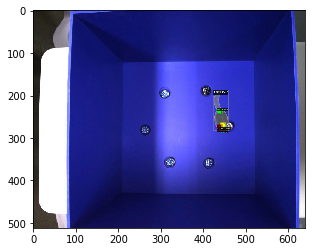

In [16]:
for d in random.sample(dataset_dicts, 2):
    if '\\' in d['file_name']:
        d['file_name'] = d['file_name'].replace('\\','/')
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    if IN_COLAB:
        cv2_imshow(out.get_image()[:, :, ::-1])
    else:
        plt.imshow(out.get_image()[:, :, ::-1])
        

## Train!

Now, let's fine-tune the COCO-pretrained R50-FPN Mask R-CNN model with our custom dataset. It takes ~2 hours to train 3000 iterations on Colab's K80 GPU, or ~1.5 hours on a P100 GPU.


In [17]:
if GPU:
    !nvidia-smi

In [18]:
from detectron2.engine import DefaultTrainer

In [19]:
cfg = get_cfg()

In [20]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [21]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  4 #@param
cfg.SOLVER.BASE_LR = 0.0025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 3000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 #@param 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[02/03 15:24:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/03 15:24:45 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json


[02/03 15:24:45 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.


[02/03 15:24:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


[02/03 15:24:45 d2.data.build]: Using training sampler RepeatFactorTrainingSampler


[02/03 15:24:45 d2.data.common]: Serializing 118 elements to byte tensors and concatenating them all ...


[02/03 15:24:45 d2.data.common]: Serialized dataset takes 0.31 MiB


WARNING [02/03 15:24:45 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.


Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.


Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.


Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.


Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) in the model! You might want to double check if this is expected.


Skip loading parameter 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.


Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [22]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [23]:
trainer.train()

[02/03 15:24:52 d2.engine.train_loop]: Starting training from iteration 0


/Users/chenyang/miniconda3/envs/ceed/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


/Users/chenyang/miniconda3/envs/ceed/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Save and download the trained model weights

In [24]:
final_model_file = os.path.join(cfg.OUTPUT_DIR,'model_final.pth')

In [25]:
if IN_COLAB:
    from google.colab import files
    files.download(final_model_file)
else:
    from IPython.display import FileLink
    FileLink(final_model_file)